# Concise Implementation of Recurrent Neural Networks

## Reading the Dataset

Here, we will work with H. G. Wells’ The Time Machine, a book containing just over 30,000 words. While real applications will typically involve significantly larger datasets, this is sufficient to demonstrate the preprocessing pipeline. The following _download method reads the raw text into a string.



In [1]:
using Downloads

file_path = Downloads.download("http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt")

"/tmp/jl_76LOtklqF4"

In [2]:
raw_text = open(io->read(io, String),file_path)
raw_text[begin:60]

"The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra"

For simplicity, we ignore punctuation and capitalization when preprocessing the raw text.

In [3]:
str = lowercase(replace(raw_text,r"[^A-Za-z]+"=>" "))
str[begin:60]

"the time machine by h g wells i the time traveller for so it"

## Tokenization

Tokens are the atomic (indivisible) units of text. Each time step corresponds to 1 token, but what precisely constitutes a token is a design choice. For example, we could represent the sentence “Baby needs a new pair of shoes” as a sequence of 7 words, where the set of all words comprise a large vocabulary (typically tens or hundreds of thousands of words). Or we would represent the same sentence as a much longer sequence of 30 characters, using a much smaller vocabulary (there are only 256 distinct ASCII characters). Below, we tokenize our preprocessed text into a sequence of characters.

In [4]:
tokens = [str...]
join(tokens[begin:30],",")

"t,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, "

## Vocabulary

We now construct a vocabulary for our dataset, converting the sequence of strings into a list of numerical indices. Note that we have not lost any information and can easily convert our dataset back to its original (string) representation.

In [5]:
vocab = unique(tokens)
vocab_len = length(vocab)

vocab_dict = Dict(vocab .=> 1:length(vocab))
indices_dict = Dict(i[2]=>i[1] for i in vocab_dict)

to_indices(v::Vector{Char}) = [vocab_dict[i] for i in v]
to_vocab(v::Vector{Int}) = [indices_dict[i] for i in v]

indices = to_indices(vocab[begin:10])
println("indices:$(indices)")
println("words:$(to_vocab(indices))")

indices:[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
words:['t', 'h', 'e', ' ', 'i', 'm', 'a', 'c', 'n', 'b']


## Exploratory Language Statistics

Using the real corpus and the Vocab class defined over words, we can inspect basic statistics concerning word use in our corpus. Below, we construct a vocabulary from words used in The Time Machine and print the ten most frequently occurring of them.

In [6]:
using TextAnalysis

sd = StringDocument(str)
crps = Corpus([sd])
update_lexicon!(crps)
lex_dict = lexicon(crps)
unigram = sort([lex_dict...]; by = x -> x[2], rev=true)
unigram[1:10]

10-element Vector{Pair{String, Int64}}:
  "the" => 2261
    "i" => 1267
  "and" => 1245
   "of" => 1155
    "a" => 816
   "to" => 695
  "was" => 552
   "in" => 541
 "that" => 443
   "my" => 440

 Word frequency tends to follow a power law distribution (specifically the Zipfian) as we go down the ranks. To get a better idea, we plot the figure of the word frequency.

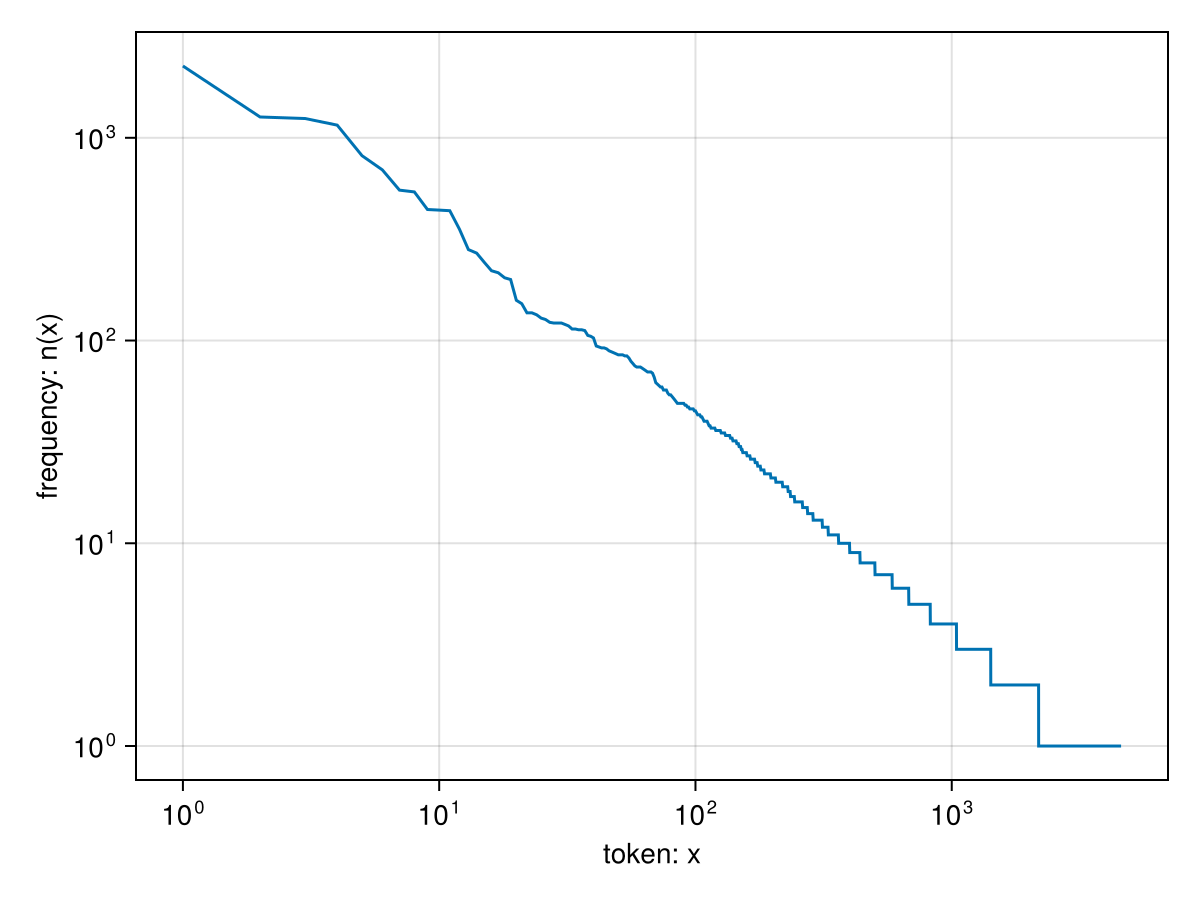

In [7]:
using CairoMakie

fg,ax = lines(last.(unigram); axis=(;xlabel = "token: x",ylabel = "frequency: n(x)", xscale = log10, yscale = log10))

This should already give us pause for thought if we want to model words by counting statistics. After all, we will significantly overestimate the frequency of the tail, also known as the infrequent words. But what about the other word combinations, such as two consecutive words (bigrams), three consecutive words (trigrams), and beyond? Let’s see whether the bigram frequency behaves in the same manner as the single word (unigram) frequency.

In [8]:
bigram = sort([ngrams(sd, 2)...]; by = x -> x[2], rev=true)
bigram[1:10]

10-element Vector{Pair{AbstractString, Int64}}:
   "of the" => 309
   "in the" => 169
    "i had" => 130
    "i was" => 112
  "and the" => 109
 "the time" => 102
   "it was" => 99
   "to the" => 85
     "as i" => 78
     "of a" => 73

One thing is notable here. Out of the ten most frequent word pairs, nine are composed of both stop words and only one is relevant to the actual book—“the time”. Furthermore, let’s see whether the trigram frequency behaves in the same manner.

In [9]:
trigram = sort([ngrams(sd, 3)...]; by = x -> x[2], rev=true)
trigram[1:10]

10-element Vector{Pair{AbstractString, Int64}}:
 "the time traveller" => 59
   "the time machine" => 30
    "the medical man" => 24
       "it seemed to" => 16
           "it was a" => 15
     "here and there" => 15
          "i did not" => 14
       "seemed to me" => 14
         "i began to" => 13
          "i saw the" => 13

Now, let’s visualize the token frequency among these three models: unigrams, bigrams, and trigrams.

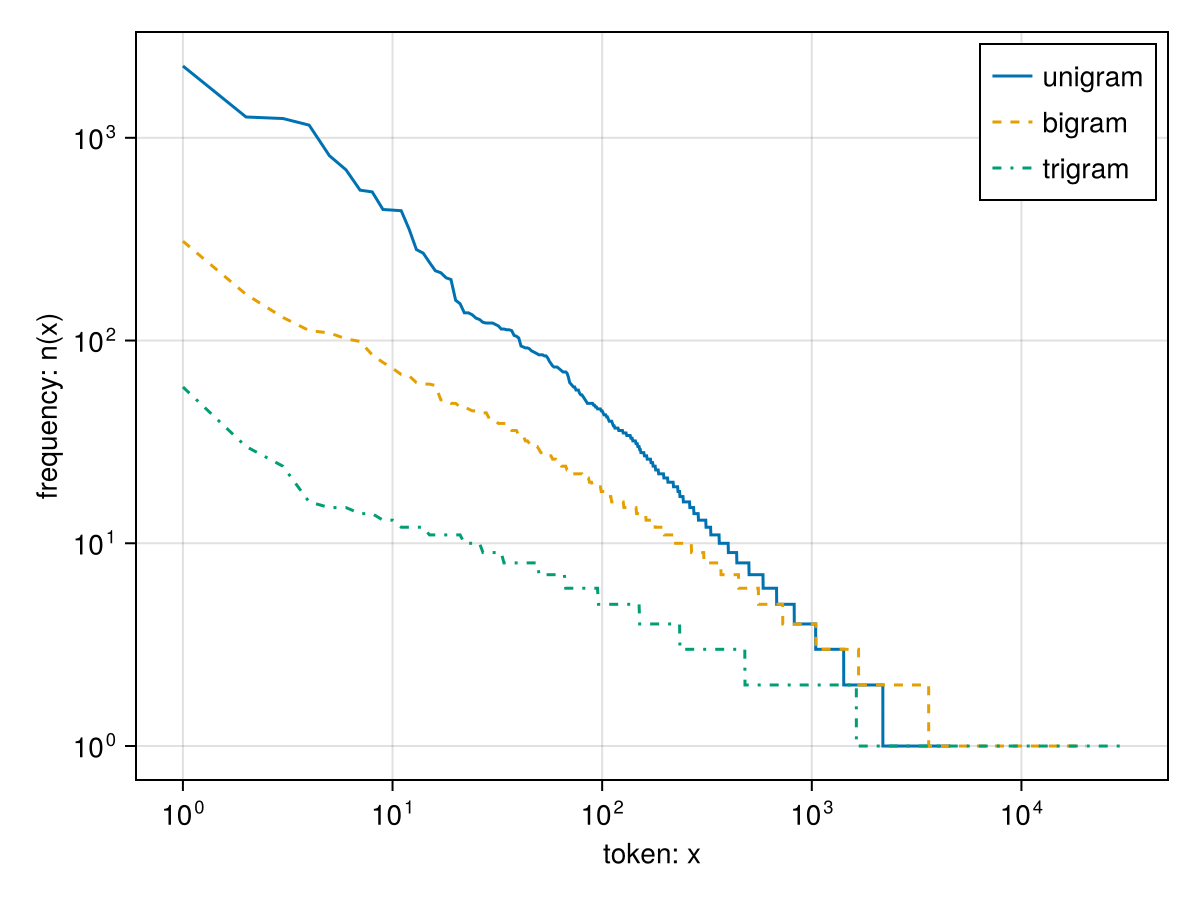

In [10]:
fg2,ax2 = lines(last.(unigram),label="unigram"; 
    axis=(;xlabel = "token: x", ylabel = "frequency: n(x)", xscale = log10, yscale = log10))
lines!(ax2,last.(bigram),label="bigram",linestyle=:dash)
lines!(ax2,last.(trigram),label="trigram",linestyle=:dashdot)
axislegend(position = :rt)
fg2

## Recurrent Neural Networks with Hidden States

To begin with, we define matrices X, W_xh, H, and W_hh, whose shapes are (3, 1), (1, 4), (3, 4), and (4, 4), respectively. Multiplying X by W_xh, and H by W_hh, and then adding these two products, we obtain a matrix of shape (3, 4).

In [11]:
X, W_xh = randn(3, 1), randn(1, 4)
H, W_hh = randn(3, 4), randn(4, 4)
X*W_xh+H*W_hh

3×4 Matrix{Float64}:
  3.27737    0.145477  1.15854  -0.197464
  1.2566    -0.501898  1.10184   0.582175
 -0.269703  -1.20752   1.29992   1.52477

Now we concatenate the matrices X and H along columns (axis 1), and the matrices W_xh and W_hh along rows (axis 0). These two concatenations result in matrices of shape (3, 5) and of shape (5, 4), respectively. Multiplying these two concatenated matrices, we obtain the same output matrix of shape (3, 4) as above.

In [12]:
cat(X,H; dims = 2)*cat(W_xh,W_hh;dims = 1)

3×4 Matrix{Float64}:
  3.27737    0.145477  1.15854  -0.197464
  1.2566    -0.501898  1.10184   0.582175
 -0.269703  -1.20752   1.29992   1.52477

## RNN-Based Language Model

When training language models, the inputs and outputs are from the same vocabulary. Hence, they have the same dimension, which is equal to the vocabulary size. Note that we use perplexity to evaluate the model, this ensures that sequences of different length are comparable.

In [13]:
using CUDA,Flux

device = Flux.get_device(; verbose=true)

┌ Info: Using backend: CUDA.
└ @ Flux /home/nero/.julia/packages/Flux/Wz6D4/src/functor.jl:662


(::Flux.FluxCUDADevice) (generic function with 1 method)

In [14]:
model = Chain(RNN(vocab_len => 32),Dense(32 => vocab_len)) |> device

opt_state = Flux.setup(Adam(1e-2), model)

function loss(model, xs, ys)
    Flux.reset!(model)
    return sum(Flux.logitcrossentropy.([model(x) for x in xs], ys))
end

loss (generic function with 1 method)

## One-Hot Encoding

For example, if the vocabulary had five elements, then the one-hot vectors corresponding to indices 1 and 3 would be the following.

In [15]:
Flux.onehotbatch([1,3],1:5)

5×2 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  ⋅
 ⋅  ⋅
 ⋅  1
 ⋅  ⋅
 ⋅  ⋅

Let’s check whether the forward computation produces outputs with the correct shape.

In [16]:
using IterTools

seq_length = 10
batch_size = 2

# n*[seq_length x feature x batch_size]
function getdata(str::String,vocab::Vector{Char},seq_length::Int,batch_size::Int)::Tuple
    data = collect.(partition(str,seq_length,1))
    x = [[Flux.onehotbatch(i,vocab) for i in d] for d in Flux.batchseq.(Flux.chunk(data[begin:end-1];size = batch_size))]
    y = [[Flux.onehotbatch(i,vocab) for i in d] for d in Flux.batchseq.(Flux.chunk(data[2:end];size = batch_size))]
    return x,y
end

x,y = getdata(str, vocab, seq_length, batch_size) |> device
for (x,y) in zip(x,y)
    Flux.reset!(model)
    output = [model(x[i]) for i in 1:seq_length]
    @show size(output)
    @show size(output[1])
    break
end

size(output) = (10,)
size(output[1]) = (27, 2)


## Decoding

Once a language model has been learned, we can use it not only to predict the next token but to continue predicting each subsequent one, treating the previously predicted token as though it were the next in the input. Sometimes we will just want to generate text as though we were starting at the beginning of a document. However, it is often useful to condition the language model on a user-supplied prefix. For example, if we were developing an autocomplete feature for a search engine or to assist users in writing emails, we would want to feed in what they had written so far (the prefix), and then generate a likely continuation.

The following predict method generates a continuation, one character at a time, after ingesting a user-provided prefix. When looping through the characters in prefix, we keep passing the hidden state to the next time step but do not generate any output. This is called the warm-up period. After ingesting the prefix, we are now ready to begin emitting the subsequent characters, each of which will be fed back into the model as the input at the next time step.

In [89]:
using StatsBase: wsample

function predict(model::Chain, prefix::String, num_preds::Int)
    model = cpu(model)
    Flux.reset!(model)
    buf = IOBuffer()
    write(buf, prefix)

    c = wsample(vocab, softmax([model(Flux.onehot(c, vocab)) for c in collect(prefix)][end]))
    for i in 1:num_preds
        write(buf, c)
        c = wsample(vocab, softmax(model(Flux.onehot(c, vocab))))
    end
    return String(take!(buf))
end

predict (generic function with 1 method)

In the following, we specify the prefix and have it generate 20 additional characters.

In [18]:
predict(model,"it has",20)

"it hasdgpbmyhpqxjlgmewm  r"

Given that we have not trained the network, it will generate nonsensical predictions.

## Training and Predicting

Next, we train our model, leveraging the high-level API.

In [ ]:
x,y = getdata(str, vocab, 32, 1024) |> device
data = zip(x,y)
loss_train = []

for epoch in 1:100
    Flux.reset!(model)
    Flux.train!(loss,model,data,opt_state)
    push!(loss_train,sum(loss.(Ref(model), x, y)) / length(str)) 
end

In [90]:
predict(model,"we are ",100)

"we are havermaglened the time the red looted and unal there the sun i i came to fast in almalinidenapy litt"

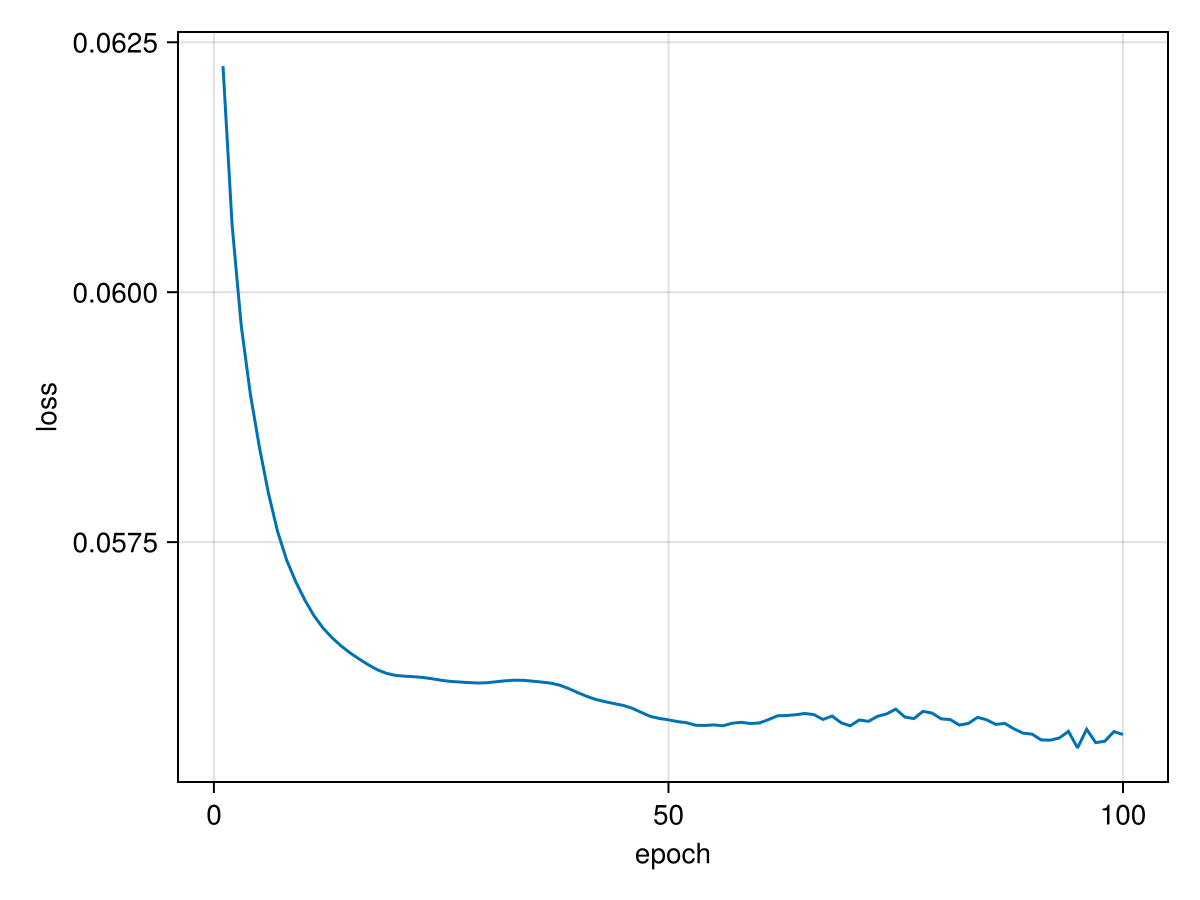

In [91]:
fg3,ax3 = lines(loss_train; axis=(;xlabel = "epoch",ylabel = "loss"))